## Optimal control of treatment in a mathematical model of chronic myelogenous leukemia 
### Seema Nanda, Helen Moore, Suzanne Lenhart, Mathematical Biosciences 210 (2007) 143–156

## (Work in Progress)

## Model Definition

In [1]:
import numpy as np
import do_mpc   #install via pip (like CRAN, gets binaries) using Python 3.6 
model_type = 'continuous' # either 'discrete' or 'continuous' 
model = do_mpc.model.Model(model_type)
Tn = model.set_variable(var_type='_x', var_name='Tn', shape=(1,1)) 
Te = model.set_variable(var_type='_x', var_name='Te', shape=(1,1)) 
Ca = model.set_variable(var_type='_x', var_name='Ca', shape=(1,1)) 
# Variables can also be vectors:
dX = model.set_variable(var_type='_x', var_name='dX', shape=(3,1)) 
# drug levels:
U1 = model.set_variable(var_type='_u', var_name='U1', shape=(1,1)) 
U2 = model.set_variable(var_type='_u', var_name='U2', shape=(1,1)) 



sn=0.29 
dn=0.35
de=0.40
dc=0.012
kn=.066
etap=140
alfn=0.39
alfe=0.65
Cmax=16e4
rc=.011
gep=.079  #ge is function greater than or equal to, so add p
gcp=.058

model.set_rhs('Tn', dX[0]) 
model.set_rhs('Te', dX[1]) 
model.set_rhs('Ca', dX[2])

from casadi import *
dX_next = vertcat( 
    sn - (1.0+U2)*dn*Tn - kn*Tn*Ca/(Ca+etap), 
    alfn*kn*Tn*Ca/(Ca+etap) + alfe*Te*Ca/(Ca+etap) - (1.0+U2)*de*Te - gep*Ca*Te, 
    (1.0-U1)*rc*Ca*log(Cmax/Ca) - (1.0+U2)*dc*Ca - gcp*Ca*Te,
)
model.set_rhs('dX', dX_next)
model.setup()

## Controller Definition

In [2]:
mpc = do_mpc.controller.MPC(model)

setup_mpc = { 
  'n_horizon': 25,
  't_step': 0.1,
  'n_robust': 1, 
  'store_full_solution': True,
} 

mpc.set_param(**setup_mpc)

B1=1000
B2=500
B3=0.1
B4=1e5

mterm = Ca 
lterm = B3*Ca - B4*Tn
mpc.set_objective(mterm=mterm, lterm=lterm)


mpc.set_rterm( U1=B1, U2=B2)

TnMax=1e4
TeMax=1e4
U1max=0.9
# U2max=2.5
U2max=1.5

# Lower bounds on states:
mpc.bounds['lower','_x', 'Tn'] = 0 
mpc.bounds['lower','_x', 'Te'] = 0 
mpc.bounds['lower','_x', 'Ca'] = 0
# Upper bounds on states 
mpc.bounds['upper','_x', 'Tn'] = TnMax 
mpc.bounds['upper','_x', 'Te'] = TeMax 
mpc.bounds['upper','_x', 'Ca'] = Cmax
# Lower bounds on inputs:
mpc.bounds['lower','_u', 'U1'] = 0 
mpc.bounds['lower','_u', 'U2'] = 0 
# Lower bounds on inputs:
mpc.bounds['upper','_u', 'U1'] = U1max 
mpc.bounds['upper','_u', 'U2'] = U2max

mpc.scaling['_x', 'Tn'] = 2 
mpc.scaling['_x', 'Te'] = 2 
mpc.scaling['_x', 'Ca'] = 2

#inertia_mass_1 = 2.25*1e-4*np.array([1., 0.9, 1.1]) 
#inertia_mass_2 = 2.25*1e-4*np.array([1., 0.9, 1.1]) 
#inertia_mass_3 = 2.25*1e-4*np.array([1.])
# mpc.set_uncertainty_values( 
#   Theta_1 = inertia_mass_1, 
#   Theta_2 = inertia_mass_2, 
#   Theta_3 = inertia_mass_3
# )

mpc.setup()

## Simulator Definition

In [3]:
simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(t_step = 0.1)
# p_template = simulator.get_p_template()
# type(p_template)
# p_template.keys()

# def p_fun(t_now): 
#   p_template['Theta_1'] = 2.25e-4 
#   p_template['Theta_2'] = 2.25e-4 
#   p_template['Theta_3'] = 2.25e-4 
#   return p_template

# simulator.set_p_fun(p_fun)
simulator.setup()

##  Estimator Definition  (none since states are measureable)

## Execution
### 1. Uncontrolled Perturbation (simulate  non-steady state initial condition)

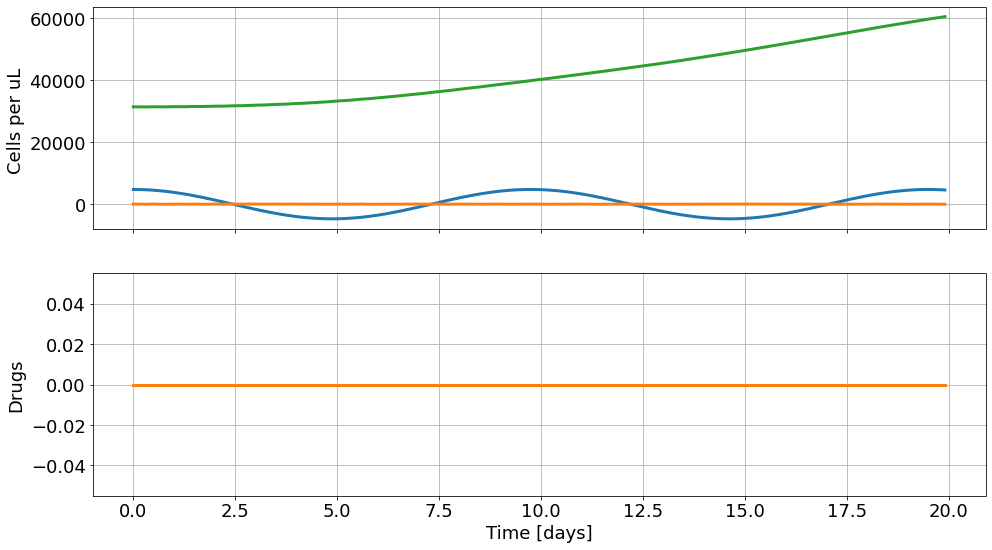

In [4]:
x0 = np.pi*np.array([1510, 10, 1e4, 0, 0, 0]).reshape(-1,1)
simulator.x0 = x0 
mpc.x0 = x0
# mpc.x0
# mpc.x0['Ca']

mpc.set_initial_guess()

import matplotlib.pyplot as plt 
import matplotlib as mpl
# Customizing Matplotlib: 
mpl.rcParams['font.size'] = 18 
mpl.rcParams['lines.linewidth'] = 3 
mpl.rcParams['axes.grid'] = True

mpc_graphics = do_mpc.graphics.Graphics(mpc.data) 
sim_graphics = do_mpc.graphics.Graphics(simulator.data)

# %%capture
# We just want to create the plot and not show it right now. This "inline magic" ˓→supresses the output.
fig, ax = plt.subplots(2, sharex=True, figsize=(16,9)) 
fig.align_ylabels()

for g in [sim_graphics, mpc_graphics]:
  # Plot cell numbers on the first axis: 
  g.add_line(var_type='_x', var_name='Tn', axis=ax[0]) 
  g.add_line(var_type='_x', var_name='Te', axis=ax[0]) 
  g.add_line(var_type='_x', var_name='Ca', axis=ax[0])
  # Plot drug levels on the second axis:
  g.add_line(var_type='_u', var_name='U1', axis=ax[1]) 
  g.add_line(var_type='_u', var_name='U2', axis=ax[1])



ax[0].set_ylabel('Cells per uL ') 
ax[1].set_ylabel('Drugs') 
ax[1].set_xlabel('Time [days]')

u0 = np.zeros((2,1))  # no controller input
for i in range(200):  # 200 steps of 0.1 takes us to 20 days
  simulator.make_step(u0)


sim_graphics.plot_results()
# Reset the limits on all axes in graphic to show the data. 
sim_graphics.reset_axes()
# Show the figure:
# fig

### 2. Controlled Perturbation

In [5]:
%%capture
u0 = mpc.make_step(x0) # one run to horizon of 25 steps taking step sizes of 0.1

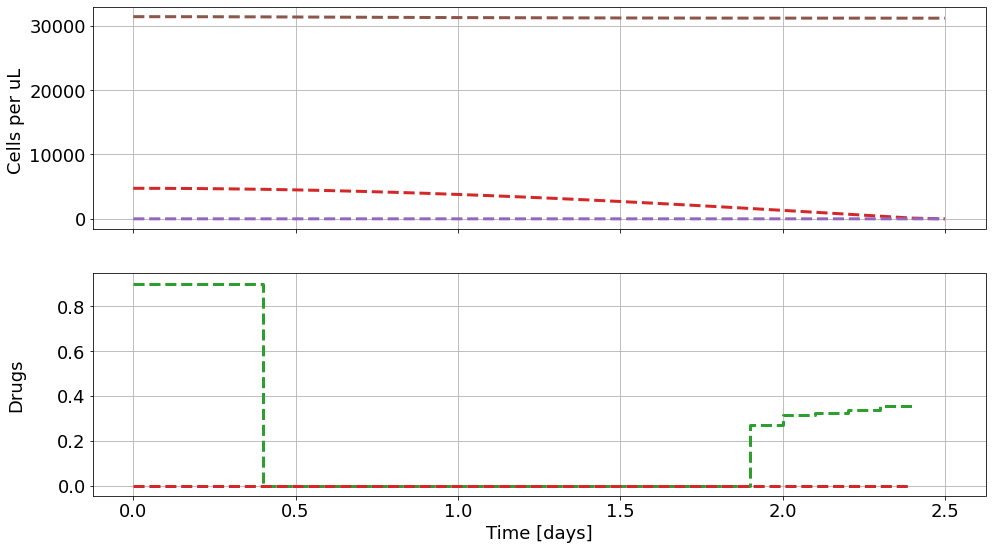

In [6]:
sim_graphics.clear()

mpc_graphics.plot_predictions() 
mpc_graphics.reset_axes()
# Show the figure:
fig

In [7]:
mpc_graphics.pred_lines
mpc_graphics.pred_lines['_x', 'Tn']

for line_i in mpc_graphics.pred_lines['_x', 'Tn']: line_i.set_color('#1f77b4') #
for line_i in mpc_graphics.pred_lines['_x', 'Te']: line_i.set_color('#ff7f0e') #
for line_i in mpc_graphics.pred_lines['_x', 'Ca']: line_i.set_color('#2ca02c') #
# Change the color for the two inputs:
for line_i in mpc_graphics.pred_lines['_u', 'U1']: line_i.set_color('#1f77b4')
for line_i in mpc_graphics.pred_lines['_u', 'U2']: line_i.set_color('#ff7f0e')
# Make all predictions transparent:
for line_i in mpc_graphics.pred_lines.full: line_i.set_alpha(0.2)

 # Get line objects (note sum of lists creates a concatenated list)
lines = sim_graphics.result_lines['_x', 'Tn']+sim_graphics.result_lines['_x', 'Te']+sim_graphics.result_lines['_x', 'Ca']
ax[0].legend(lines,'123',title='Cells')
# also set legend for second subplot:
lines = sim_graphics.result_lines['_u', 'U1']+sim_graphics.result_lines['_u', 'U2']
ax[1].legend(lines,'12',title='Drug Inputs')

simulator.reset_history() 
simulator.x0 = x0 
mpc.reset_history()

In [8]:
%%capture  
#capture above is cell magic that grabs up lengthy output
for i in range(200):
  u0 = mpc.make_step(x0)     # reruns optimal control optimization at each time step, i.e. does MPC
  x0 = simulator.make_step(u0)

The closed loop MPC result below is very similar to the open loop Pontryagin-like result above. 

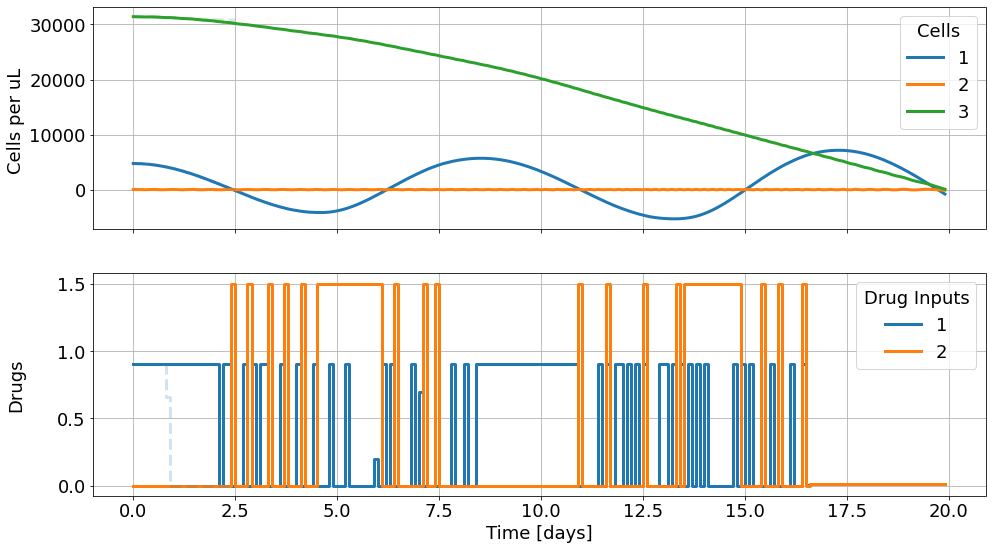

In [10]:
mpc_graphics.plot_predictions(t_ind=0) # Plot results until current time 
sim_graphics.plot_results() 
sim_graphics.reset_axes()
fig  # cells ordered as in equations 1=Tn, 2=Te, and 3=Ca. U1 (1) and U2 (2) are bang-bang controls.

optimal control is bang bang